# Get State of the Art

Here for we compare published models to get the current state of the art

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from scipy import stats
import seaborn as sns
import gpplot
import plotnine as gg


from model_predictions import model_prediction_list
from datasets import dataset_list
from core import setup_plots, no_clip

In [2]:
setup_plots()

We'll load and get unique sgRNAs for published datasets and models

In [3]:
for mp in model_prediction_list:
    mp.load_model_predictions()
    mp.set_sgrnas()

for ds in dataset_list:
    ds.load_data()
    ds.set_sgrnas()

model_datasets = model_prediction_list + dataset_list

In [4]:
model_data_summaries = []
for data in model_datasets:
    summary = dict()
    summary['name'] = data.name
    summary['data_type'] = data.classtype
    summary['n_sgRNAs'] = len(data.sgrnas)
    model_data_summaries.append(summary)

model_data_summary_df = pd.DataFrame(model_data_summaries)
model_data_summary_df.sort_values('n_sgRNAs')

,name,data_type,n_sgRNAs
11,Kim2019_test,dataset,536
8,Doench2014_human,dataset,995
14,Wang2014,dataset,1022
7,Doench2014_mouse,dataset,1168
6,Chari2015,dataset,1176
9,Doench2016,dataset,2536
2,Rule Set 2,model,4379
13,Shalem_2014,dataset,4766
12,Koike-Yusa2014,dataset,6689
5,Aguirre2017,dataset,8659


## Overlap between datasets and models

For each dataset and model we'll calculate the fraction of sgRNAs that each library shares with one another

In [5]:
dataset_model_overlaps = []
for ds in dataset_list:
    for m in model_prediction_list:
        dataset_model_overlap = dict()
        dataset_model_overlap['name_1'] = ds.name
        dataset_model_overlap['name_2'] = m.name
        common_sgrnas = (pd.Series(list(ds.sgrnas))
                         .isin(list(m.sgrnas))
                         .sum())
        dataset_model_overlap['overlap'] = common_sgrnas
        dataset_model_overlaps.append(dataset_model_overlap)

dataset_model_overlap_df = pd.DataFrame(dataset_model_overlaps)
dataset_model_overlap_df = dataset_model_overlap_df[dataset_model_overlap_df['overlap'] > 0].reset_index(drop=True)
dataset_model_overlap_df = (dataset_model_overlap_df.merge(model_data_summary_df
                                                           .rename({'name': 'name_1'}, axis=1),
                                                           how='inner', on='name_1')
                            .merge(model_data_summary_df
                                   .rename({'name': 'name_2'}, axis=1),
                                   how='inner', on='name_2', suffixes=('_1', '_2')))
dataset_model_overlap_df['fraction_overlap'] = dataset_model_overlap_df['overlap']/dataset_model_overlap_df['n_sgRNAs_1']


<ipython-input-6-a6caa8350b1c>:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


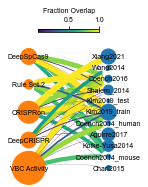

In [6]:
G = nx.from_pandas_edgelist(dataset_model_overlap_df, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (model_data_summary_df[['name', 'n_sgRNAs', 'data_type']]
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
fig, ax = plt.subplots(figsize=(2.2,3.2))
# layout
pos = nx.bipartite_layout(G, [x for x, y in G.nodes(data=True) if y['data_type'] == 'model'])
# edges
edge_width = [d['fraction_overlap']*6 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap', location='top',
             shrink=0.5)
# nodes
node_size = [d['n_sgRNAs'] * 0.02 for _, d in G.nodes(data=True)]
node_color = ['tab:blue' if d['data_type'] == 'dataset' else 'tab:orange' for _, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
# labels
labels = nx.draw_networkx_labels(G, pos, font_size=7,
                                 font_family='Arial')
no_clip(ax)
plt.axis('off')
plt.margins(x=0.2)
plt.draw()
gpplot.savefig('../figures/model_training_network.pdf')

## Model Performance

In [7]:
model_comparison_list = []
for i in range(len(model_prediction_list)):
    for j in range(i+1, len(model_prediction_list)):
        pred1 = model_prediction_list[i]
        pred2 = model_prediction_list[j]
        joined_predictions = pred1.prediction_df.merge(pred2.prediction_df, how='inner',
                                                       on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
        filtered_predictions = joined_predictions[~joined_predictions['sgRNA Sequence'].isin(pred1.sgrnas) &
                                                  ~joined_predictions['sgRNA Sequence'].isin(pred2.sgrnas)]
        for ds in dataset_list:
            ds_predictions = filtered_predictions.merge(ds.dataset, how='inner',
                                                        left_on=['sgRNA Sequence', 'sgRNA Context Sequence'],
                                                        right_on=[ds.sgrna_seq_col, ds.context_seq_col])
            if ds_predictions.shape[0] > 50:
                performance_dict = {}
                performance_dict['model1'] = pred1.name
                performance_dict['model2'] = pred2.name
                performance_dict['dataset'] = ds.name
                performance_dict['size'] = ds_predictions.shape[0]
                performance_dict['model1_spearman'] = stats.spearmanr(ds_predictions[pred1.prediction_col],
                                                                      ds_predictions[ds.rank_col])[0]
                performance_dict['model2_spearman'] = stats.spearmanr(ds_predictions[pred2.prediction_col],
                                                                      ds_predictions[ds.rank_col])[0]
                model_comparison_list.append(performance_dict)

performance_df = pd.DataFrame(model_comparison_list)
performance_df['difference'] = performance_df['model1_spearman'] - performance_df['model2_spearman']
performance_df['relative_performance'] = performance_df['model1_spearman']/performance_df['model2_spearman']
model_order = ['CRISPRon', 'DeepSpCas9', 'Rule Set 2', 'VBC Activity', 'DeepCRISPR']
performance_df['model1'] = pd.Categorical(performance_df['model1'],
                                          categories=model_order)
performance_df['model2'] = pd.Categorical(performance_df['model2'],
                                          categories=model_order)
performance_df['dataset'] = performance_df['dataset'].astype('category')
performance_df.head()

,model1,model2,dataset,size,model1_spearman,model2_spearman,difference,relative_performance
0,CRISPRon,DeepSpCas9,Aguirre2017,8292,0.538493,0.525404,0.013090,1.024913
1,CRISPRon,DeepSpCas9,Chari2015,1164,0.475802,0.444264,0.031539,1.070991
2,CRISPRon,DeepSpCas9,Doench2014_mouse,475,0.445748,0.432528,0.013220,1.030565
3,CRISPRon,DeepSpCas9,Doench2014_human,280,0.457960,0.454119,0.003841,1.008459
4,CRISPRon,DeepSpCas9,Doench2016,453,0.387116,0.391341,-0.004226,0.989202


We can see that DeepSpCas9 consistently outperforms Rule Set 2, and DeepCRISPR is consistently the worst model

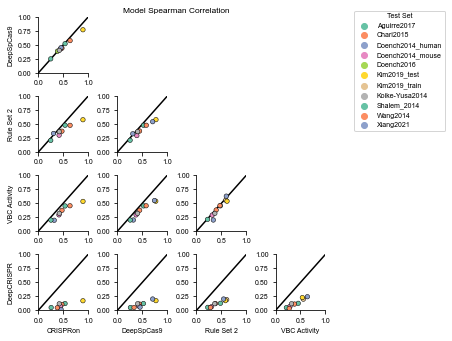

In [8]:
def const_line(ax, *args, **kwargs):
    ax.plot([0, 1], [0, 1], color='black')

fig, axs = plt.subplots(ncols=4, nrows=4,
                        figsize=(4.5, 4.5))
fig.tight_layout()

for i in range(len(model_order) - 1):
    model1 = model_order[i]
    for j in range(1, len(model_order)):
        ax = axs[j-1, i]
        if j <= i:
            fig.delaxes(ax)
        else:
            model2 = model_order[j]
            comp_df = performance_df[(performance_df['model1'] == model1) &
                                     (performance_df['model2'] == model2)].copy()
            sns.scatterplot(data=comp_df,
                            x='model1_spearman', y='model2_spearman',
                            hue='dataset', palette='Set2',
                            edgecolor='black', linewidth=0.5, ax=ax,
                            s=20, zorder=2.5)
            const_line(ax)

            ax.get_legend().remove()
            if i == 0:
                ylab = model2
            else:
                ylab = ''
            if j == 4:
                xlab = model1
            else:
                xlab = ''
            ax.set(xlim=(0,1), ylim=(0,1),
                   xlabel=xlab, ylabel=ylab)
            sns.despine(ax=ax)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.04,1), loc="upper left",
           title='Test Set')
fig.suptitle('Model Spearman Correlation', va='bottom')

gpplot.savefig('../figures/model_performance.pdf')

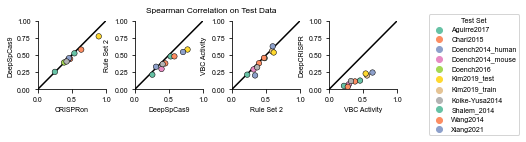

In [9]:
salient_comparisons = [('CRISPRon', 'DeepSpCas9'),
                       ('DeepSpCas9', 'Rule Set 2'),
                       ('Rule Set 2', 'VBC Activity'),
                       ('VBC Activity', 'DeepCRISPR')]
fig, axs = plt.subplots(ncols=4, nrows=1,
                        figsize=(5.5, 5.5/4))
fig.tight_layout()
for i, (model1, model2) in enumerate(salient_comparisons):
    ax = axs[i]
    comp_df = performance_df[(performance_df['model1'] == model1) &
                                     (performance_df['model2'] == model2)].copy()
    sns.scatterplot(data=comp_df,
                    x='model1_spearman', y='model2_spearman',
                    hue='dataset', palette='Set2',
                    edgecolor='black', linewidth=0.5, ax=ax,
                    s=30, zorder=2.5)
    const_line(ax)
    ax.get_legend().remove()
    ax.set(xlim=(0,1), ylim=(0,1),
                   xlabel=model1, ylabel=model2)
    sns.despine(ax=ax)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.04,1), loc="upper left",
           title='Test Set')
fig.suptitle('Spearman Correlation on Test Data', va='bottom')
gpplot.savefig('../figures/salient_model_performance.pdf')



In [10]:
performance_comparison_df = performance_df.copy()
performance_comparison_df['comparison'] = (performance_df['model1'].astype(str) + '_' +
                                           performance_df['model2'].astype(str))
performance_df_model1 = (performance_comparison_df[['model1', 'model1_spearman', 'dataset', 'size', 'comparison']]
                         .copy()
                         .rename({'model1': 'model', 'model1_spearman': 'spearman'}, axis=1))
performance_df_model2 = (performance_comparison_df[['model2', 'model2_spearman', 'dataset', 'size', 'comparison']]
                         .copy()
                         .rename({'model2': 'model', 'model2_spearman': 'spearman'}, axis=1))
long_performance_df = (pd.concat([performance_df_model1, performance_df_model2])
                       .reset_index(drop=True))
long_performance_df['dataset'] = long_performance_df['dataset'].astype('str')
model_average_performance = (long_performance_df.groupby('model')
                             .agg({'spearman': 'mean'})
                             .sort_values('spearman')
                             .reset_index())
dataset_max_size = (long_performance_df.groupby('dataset')
                    .agg({'size': 'max'})
                    .sort_values('size')
                    .reset_index())
comparison_average_performance = (long_performance_df.groupby('comparison')
                                  .agg({'spearman': 'mean'})
                                  .sort_values('spearman')
                                  .reset_index())
long_performance_df['model'] = pd.Categorical(long_performance_df['model'],
                                              categories=model_average_performance['model'])
long_performance_df['dataset'] = pd.Categorical(long_performance_df['dataset'],
                                                categories=dataset_max_size['dataset'])
long_performance_df['comparison'] = pd.Categorical(long_performance_df['comparison'],
                                                   categories=comparison_average_performance['comparison'])

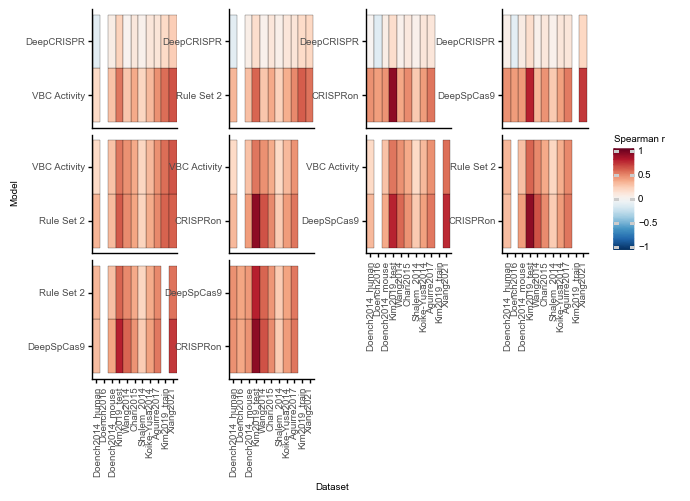

<ggplot: (8791100120736)>

In [11]:
g = (gg.ggplot(long_performance_df) +
     gg.aes(y='model', x='dataset', fill='spearman') +
     gg.geom_tile(color='black') +
     gg.scale_fill_cmap('RdBu_r', limits=(-1, 1)) +
     gg.guides(fill=gg.guide_colorbar(barwidth=10, barheight=10,
                                          title='Spearman r', raster=True)) +
     gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1),
              strip_text=gg.element_blank(),
              subplots_adjust={'wspace': 0.6},
              plot_background=gg.element_blank()) +
     gg.facet_wrap('comparison', scales='free_y', nrow=3) +
     gg.ylab('Model') +
     gg.xlab('Dataset'))
#g.save('../figures/model_performance_heatmap.pdf', width=7, height=4)
g

In [12]:
average_difference = (performance_df.groupby(['model1', 'model2'])
                      .apply(lambda df: ((df['model1_spearman'] - df['model2_spearman'])*df['size']).sum()/
                                        df['size'].sum())
                      .reset_index(name='avg_difference'))
average_difference.sort_values(['model1', 'model2'])

,model1,model2,avg_difference
0,CRISPRon,DeepSpCas9,0.016160
1,CRISPRon,Rule Set 2,0.067491
2,CRISPRon,VBC Activity,0.094013
3,CRISPRon,DeepCRISPR,0.344950
4,DeepSpCas9,Rule Set 2,0.088925
5,DeepSpCas9,VBC Activity,0.078450
6,DeepSpCas9,DeepCRISPR,0.390018
7,Rule Set 2,VBC Activity,0.029567
8,Rule Set 2,DeepCRISPR,0.323534
9,VBC Activity,DeepCRISPR,0.279512


## Picking training data
Since DeepSpCas9 is the current state of the art, we'll start with the Kim2019_train data as our training seed,
and then include all data with more than 50% overlap with the Kim2019_train data,
as well as the Wang2014 data to expand the training set.


In [13]:
dataset_overlaps = []
for ds1 in dataset_list:
    for ds2 in dataset_list:
        if ds1 != ds2:
            dataset_overlap = dict()
            dataset_overlap['name_1'] = ds1.name
            dataset_overlap['name_2'] = ds2.name
            common_context = (ds1.dataset[ds1.context_seq_col]
                              .isin(ds2.dataset[ds2.context_seq_col])
                              .sum())
            dataset_overlap['overlap'] = common_context
            dataset_overlaps.append(dataset_overlap)

dataset_overlap_df = pd.DataFrame(dataset_overlaps)
dataset_overlap_df = dataset_overlap_df[dataset_overlap_df['overlap'] > 0].reset_index(drop=True)
# directional overlap
dataset_overlap_df = (dataset_overlap_df.merge(model_data_summary_df
                                               .rename({'name': 'name_1'}, axis=1),
                                               how='inner', on='name_1'))
dataset_overlap_df['fraction_overlap'] = dataset_overlap_df['overlap']/dataset_overlap_df['n_sgRNAs']

In [14]:
def get_overlapping_datasets(datasets, sink_node, data, threshold=0.2):
    """Recursively get datasets which overlap with sink_node greater than a give threshold

    :param datasets: list
    :param sink_node: str
    :param data: DataFrame
    :param threshold: float
    """
    datasets.append(sink_node)
    overlapping_nodes = data.loc[(data['name_2'] == sink_node) &
                                 (data['fraction_overlap'] > threshold), 
                                 'name_1'].to_list()
    if len(overlapping_nodes) != 0:
        filtered_data = data[~data['name_1'].isin(overlapping_nodes)].copy()
        for node in overlapping_nodes:
            get_overlapping_datasets(datasets, node, filtered_data, threshold)
            
train_datasets = []
get_overlapping_datasets(train_datasets, 'Kim2019_train', dataset_overlap_df)
get_overlapping_datasets(train_datasets, 'Wang2014', dataset_overlap_df)
get_overlapping_datasets(train_datasets, 'Xiang2021', dataset_overlap_df)
train_datasets

['Kim2019_train',
 'Doench2014_mouse',
 'Doench2014_human',
 'Doench2016',
 'Wang2014',
 'Xiang2021']

In [15]:
sgrna_train_dfs_list = list()
sgrna_test_dfs_list = list()
for ds in dataset_list:
    if ds.name in train_datasets:
        sgrna_train_dfs_list.append(ds.get_sg_df())
    else:
        sgrna_test_dfs_list.append(ds.get_sg_df())
        

train_sgrna_df = (pd.concat(sgrna_train_dfs_list)
                  .drop_duplicates())
test_sgrna_df = (pd.concat(sgrna_test_dfs_list)
                 .drop_duplicates())
print("Train sgRNAs: " + str(train_sgrna_df.shape[0]))
print("Test sgRNAs: " + str(test_sgrna_df.shape[0]))

Train sgRNAs: 26339
Test sgRNAs: 18937


In [16]:
data_summary_df = model_data_summary_df.loc[model_data_summary_df['data_type'] == 'dataset',
                                            ['name', 'n_sgRNAs']].copy()
data_summary_df['Train'] = data_summary_df['name'].isin(train_datasets)

<ipython-input-17-3a63444a59eb>:18: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


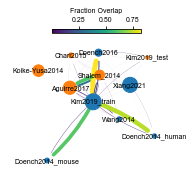

In [17]:
G = nx.from_pandas_edgelist(dataset_overlap_df, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (data_summary_df
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
plt.subplots(figsize=(3.2,3))
# layout
pos = nx.spring_layout(G, seed=3, iterations=100)
# edges
edge_width = [d['fraction_overlap']*6 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale,
                               arrowsize=5)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap', location='top',
             shrink=0.5)
# nodes
node_size = [d['n_sgRNAs'] * 0.02 for _, d in G.nodes(data=True)]
node_color = ['tab:blue' if d['Train'] else 'tab:orange' for _, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
# labels
nx.draw_networkx_labels(G, pos, font_size=7,
                        font_family='Arial')
plt.axis('off')
plt.margins(x=0.2)
gpplot.savefig('../figures/train_dataset_network.pdf')


## Write list of training data

In [18]:
train_data_name_df = pd.DataFrame({'name': train_datasets})
train_data_name_df.to_csv('../data/processed/train_data_names.csv', index=False)